## start template code

# MNIST DataSet
dataset download(.gz file) by request

## 1-1. MNIST Dataset with file(flattened)

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

assign MNIST numpy array dataset using `pickle` library

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

good to see the first MNIST hand written data

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

print to verify Pytorch Tensors

In [ ]:
print(x_train.shape)
print(y_train.min(), y_train.max())

### use DataLoader and TensorDataset

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

## 1-2. Alternative Method to get MNIST Dataset

In [1]:
from torchvision import datasets, transforms
download_root = 'test-data'
mnist_transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=True,  download=True)
test_dataset  = datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True)

### check the dataset

In [2]:
x_train2 = train_dataset.train_data
y_train2 = train_dataset.train_labels
print(x_train2.shape)
print(y_train2.min(), y_train2.max())

torch.Size([60000, 28, 28])
tensor(0) tensor(9)


/home/sky/anaconda3/envs/ai/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/sky/anaconda3/envs/ai/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


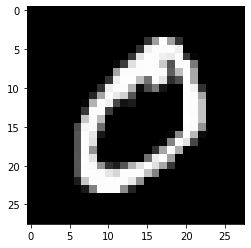

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train2[1], cmap="gray")

In [4]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=False)

## 2-1.Logsitic Regression Model

In [ ]:
from torch import nn
import torch.nn.functional as F

# Logistic model using Parameter
'''
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias
'''
# Logistic model using Linear
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)
    
#     def forward(self, xb):
#         x = self.lin(xb)
#         return F.log_softmax(x,dim=1)

## 2-2. CNN Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

## 3-1. define loss function and output function

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

## 3-2. define loss function and output function

In [14]:
import torch.nn.functional as F

loss_func = F.nll_loss

## 4. Define Optimizer and Make Function to get Model and Optimizer

In [15]:
from torch import optim

def get_model(type):
    if type == 1:
        model = Mnist_Logistic()
    elif type == 2:
        model = Net()
    else:
        model = Net()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

## 5. loss function and batch

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

## 6. hyperparameters settings

In [17]:
bs = 64  # batch size
lr = 0.1  # learning rate
epochs = 5  # how many epochs to train for
log_interval = 50 # log inverval to write

# 7. `fit` method

In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

## 7-2. fit method

In [18]:
import torch

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader):
    losses = []
    nums = []
    accs = []
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            acc = accuracy(output,target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), acc*100))
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                output = model(data)
                loss = loss_func(output, target)
                acc = accuracy(output,target)
                losses.append(loss)
                accs.append(acc)
                nums.append(len(data))
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(accs, nums)) / np.sum(nums)
        print('Valid Epoch: {} \tLoss: {:.6f}\tAccuracy: {}'.format(epoch+1, val_loss, val_acc*100.))

## 8-1. getting data and model fitting

In [ ]:
loss_func = F.cross_entropy
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model(1)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

## 8-2. getting data and model fitting

In [25]:
loss_func = F.nll_loss
model, opt = get_model(2)
fit(epochs, model, loss_func, opt, train_loader, valid_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335695	Accuracy: 14.0625
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.243395	Accuracy: 59.375
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.123877	Accuracy: 64.0625
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.634759	Accuracy: 81.25
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.608361	Accuracy: 78.125
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.457877	Accuracy: 84.375
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.377410	Accuracy: 92.1875
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.332936	Accuracy: 90.625
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.392134	Accuracy: 89.0625
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.574285	Accuracy: 85.9375
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.694810	Accuracy: 76.5625
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.310987	Accuracy: 90.625


KeyboardInterrupt: 

In [ ]:
loss_func = F.nll_loss
model, opt = get_model(2)
# Substitute model
PATH = './mnist_init_net.pt'
model = Net()
model.load_state_dict(torch.load(PATH))
fit(epochs, model, loss_func, opt, train_loader, valid_loader)

In [27]:
loss_func = F.nll_loss
model, opt = get_model(2)
# Substitute model
PATH = './mnist_init_net_checkpoint.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
fit(epochs, model, loss_func, opt, train_loader, valid_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340531	Accuracy: 12.5
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.297997	Accuracy: 17.1875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.256374	Accuracy: 26.5625
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.270495	Accuracy: 15.625
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.197659	Accuracy: 28.125
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.091682	Accuracy: 34.375
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.886091	Accuracy: 23.4375


KeyboardInterrupt: 

## 9. Save Trained Model

In [ ]:
PATH = './mnist_net.pth'
torch.save(model.state_dict(), PATH)

## 10. Save ONNX Model

In [ ]:
x = torch.randn(batch_size, 1, 28, 28, requires_grad=True)

torch.onnx.export(model,                                         # model being run
                  x,                                             # model input (or a tuple for multiple inputs)
                  "mnist_net.onnx",                              # where to save the model (can be a file or file-like object)
                  export_params=True,                            # store the trained parameter weights inside the model file
                  verbose=True, 
                  input_names = ['input'],                       # the model's input names
                  output_names = ['output'],                     # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
import onnx

# Load the ONNX model
model_onnx = onnx.load("mnist_net.onnx")

In [ ]:
# Check that the IR is well formed
onnx.checker.check_model(model_onnx)

In [ ]:
# Print a human readable representation of the graph
onnx.helper.printable_graph(model_onnx.graph)

In [ ]:
x = []
for idx, (xb, yb) in enumerate(test_loader):
    if idx == 0:
        x = xb
        break

torch_out = model(x)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("mnist_net.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [ ]:
def test(model, loss_func, optimizer, test_loader):
    losses = []
    nums = []
    accs = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(data)}
            ort_outs = ort_session.run(None, ort_inputs)
            #output = model(data)
            output = torch.Tensor(ort_outs[0])
            loss = loss_func(output, target)
            acc = accuracy(output,target)
            losses.append(loss)
            accs.append(acc)
            nums.append(len(data))
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(accs, nums)) / np.sum(nums)
        print('Loss: {:.6f}\tAccuracy: {}'.format(val_loss, val_acc*100.))

In [ ]:
test(model, loss_func, optimizer, test_loader)